In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

# Exploration

Lets have a look at a sample image, to be used for caliberation. Print out the size of the image

# Calibration

We can observe that there are 9 corners in a row and 6 corners in a column. I have used `glob` to iterate over all the `camera_cal` images to extract the object and image points

# Distortion Correction Example

We use the `cameraMatrix` and `distortionCoeffs` to undistort the image.


# Gradients and color transforms

We use 2 kinds of gradient thresholds:

1. Along the X axis.
2. Directional gradient with thresholds of 30 and 90 degrees.

This is done since the lane lines are more or less vertical.

We then apply the following color thresholds:

1. R & G channel thresholds so that yellow lanes are detected well.
2. L channel threshold so that we don't take into account edges generated due to shadows.
3. S channel threshold since it does a good job of separating out white & yellow lanes.

In [2]:
def get_thresholded_image(img):
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    s_thresh_min = 145
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 175
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 185
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

   
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1


    return combined_binary
    
    
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

# Example: Binary Thresholded Image

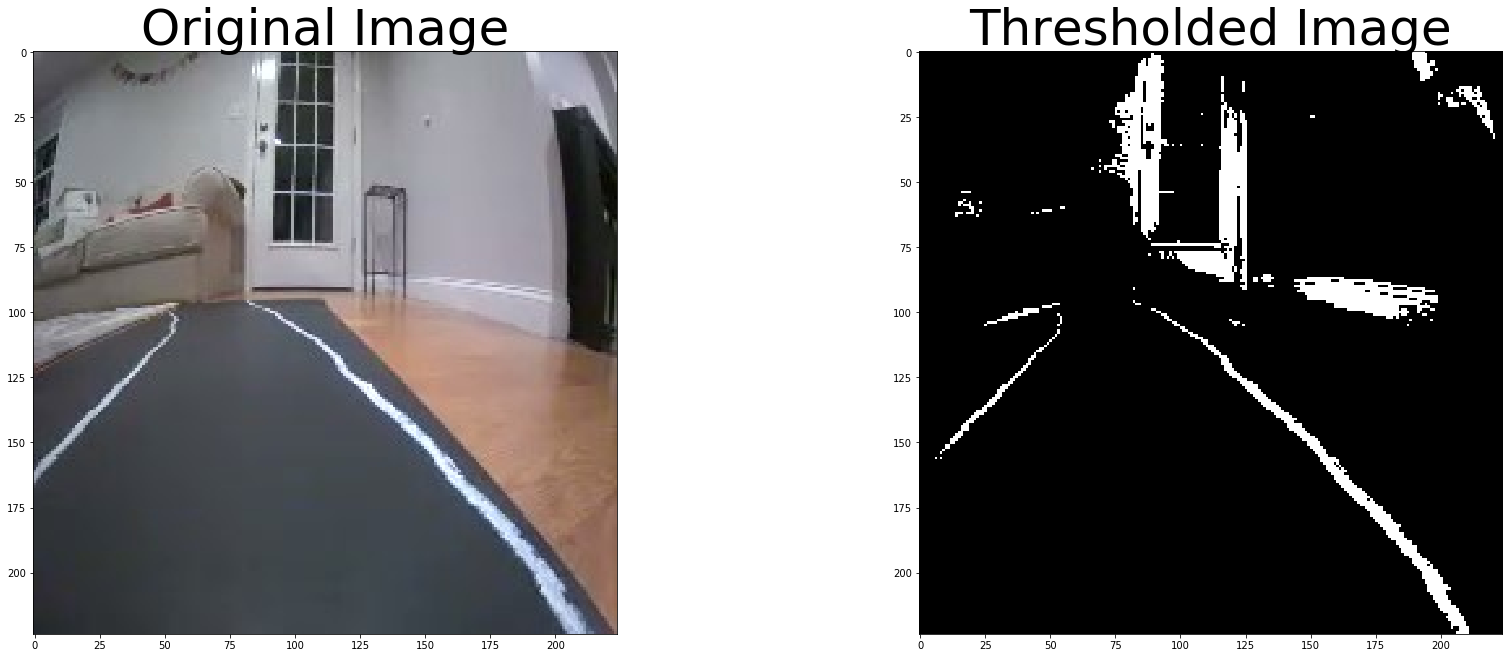

In [3]:
img = mpimg.imread('test_images/test21.jpg')
thresholded = get_thresholded_image(img)

cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

After manually examining a sample image, I extracted the vertices to perform a perspective transform. The polygon with these vertices is drawn on the image for visualization. Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.

The transform and its inverse are computer, for use later. We then transform the binary image to show the birds eye view.

In [ ]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [0,195]
bottom_right = [220, 195]
top_left = [145,110]
top_right = [60,110]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [25 ,224]
bottom_right = [185  ,224]
top_left = [185 ,0]
top_right = [25 ,0]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (224,224)

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)

    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Identifying the lane pixels: Part 1


## Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

4 155


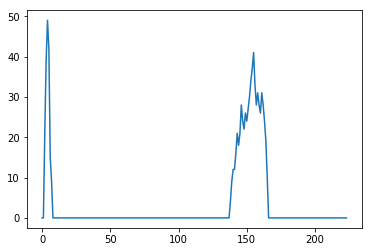

In [5]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width

print(leftx_base, rightx_base)
plt.plot(histogram)

# Identifying the lane pixels: Part 2

## Sliding Window Search

I then perform a sliding window search, starting with the base likely positions of the 2 lanes, calculated from the histogram. I have used 10 windows of width 100 pixels.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

# Identifying the lane pixels: Part 3

## Searching around a previously detected line.

Since consecutive frames are likely to have lane lines in roughly similar positions, in this section we search around a margin of 50 pixels of the previously detected lane lines.

(224, 0)

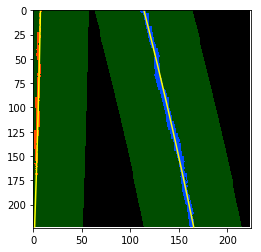

In [7]:
margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

# Computing the radius of curvature and center offset.

The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [8]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/224 # meters per pixel in y dimension
    xm_per_pix = 3.7/224 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[223] + left_x_predictions[223])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = (img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 9490.89 m
Center offset: 0.15 m


# Inverse Transform

In this block of code we:
1. Paint the lane area
2. Perform an inverse perspective transform
3. Combine the precessed image with the original image.

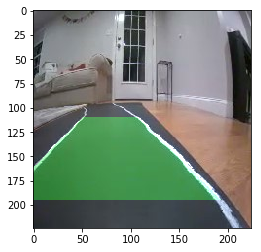

In [9]:
out_img = np.dstack((warped, warped, warped))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))

cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

plt.imshow(result)

# Tying up all together and MORE!

## Figuring out bad frames
There will be some frames where no lanes will be detected or the lanes might not make sense. We determine the bad frames if any of the following conditions are met:

1. No pixels were detected using the sliding window search or search around the previously detected line.
2. The average gap between the lanes is less than 0.7 times pr greater than 1.3 times the globally maintained moving average of the lane gap.

## Averaging lanes

The lane for each frame is a simple average of 12 previously computed lanes. This is done in the `get_averaged_line` method in the code block below.

## What to do if a bad frame is detected?

1. Perform a sliding window search again (this is done in the `brute_search` method in the code block below
2. If this still results in a bad frame then we fall back to the previous well detected frame.

## Final Pipeline
We combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the `pipeline_final` method.

In [18]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

running_mean_difference_between_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    """
        Given ncoordinates of non-zeros pixels and coordinates of non-zeros pixels within the sliding windows,
        this function generates a prediction for the lane line.
    """
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    polyfit_right = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]
    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return left_x_predictions, right_x_predictions

def brute_search(warped):
    """
        This function searches for lane lines from scratch.
        Thresholding & performing a sliding window search.
    """
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 12
    window_height = np.int(num_rows/num_windows)
    window_half_width = 25

    min_pixels = 50

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 1
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    img_size = (224,224)
    
    # get thresholded image
    thresholded = get_thresholded_image(img)
    
    # perform a perspective transform
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[195] + left_x_predictions[195])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs((img_size[0]/2) - lane_center)
    center_offset_pixels_signed = (102 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    center_offset_mtrs_signed = xm_per_pix*center_offset_pixels_signed
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    offset_string2 = "Center offset: %.2f m" % center_offset_pixels_signed

    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (2,20),cv2.FONT_HERSHEY_SIMPLEX, 0.42, (255,255,255), thickness=1)
    cv2.putText(result, offset_string2, (2,50),cv2.FONT_HERSHEY_SIMPLEX, 0.42, (255,255,255), thickness=1)
    #finalResult = np.array([result], [center_offset_pixels_signed])
#    return offset_string
    return center_offset_pixels_signed
    #return result
    #return finalInfo


# Example Result

We apply the pipeline to a test image. The original image and the processed image are shown side by side.

TypeError: Invalid dimensions for image data

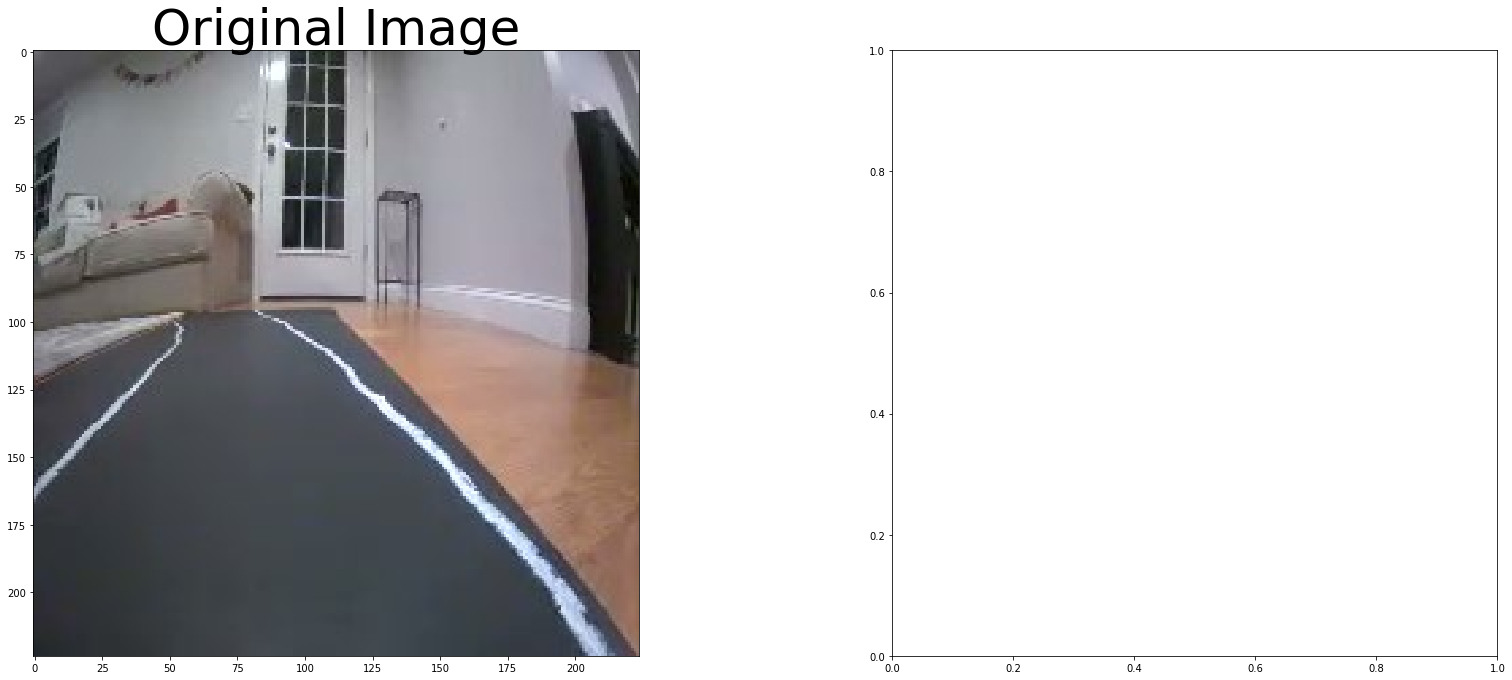

In [11]:
img = mpimg.imread('test_images/test21.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)
# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = '2.mp4'
clip1 = VideoFileClip("carvidleft.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

In [12]:
import traitlets
from IPython.display import display
import ipywidgets.widgets as widgets
from jetbot import Camera, bgr8_to_jpeg
import time
from jetbot import Robot

def RobotController(robot,img):
    
    rightside = False
    leftside = False
    xintercept=0
    
    signed_center_offset = pipeline_final(img)
    #print("RobotController:signed_center_offset:",signed_center_offset)
    
    k = -0.0021

    error = 0 - signed_center_offset
    motor_speed_change = error*k
    if error < 0: 
        robot.set_motors(-0.2,-0.2-motor_speed_change)
        print('right')
        
    elif error > 0:
        robot.set_motors(-0.2+motor_speed_change,-0.2)
        print('left')
    elif error == 0:
        robot.set_motors(-0.2,-0.2)
        print('straight')
     
        
    
   #robot.set_motors(left_motor, right_motor)
    
    
    #print(signed_center_offset)
    #print(result)
    
    
    return signed_center_offset


In [14]:
camera = Camera.instance(width=224, height=224) 
robot = Robot()


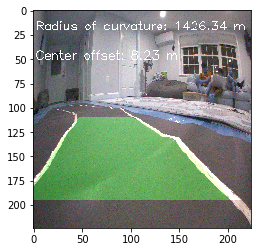

In [17]:
    img = camera.value
    #offsetstring, signed_center_offset = pipeline_final(img)
    plt.imshow(img)

    result = pipeline_final(img)
    plt.imshow(result)
    #print(millis)
    




In [87]:
x=0
while ( x < 1000):
    img = camera.value
    #offsetstring, signed_center_offset = pipeline_final(img)
    RobotController(robot,img)
    #print(offsetstring)
    #millis = int(round(time.time() * 1000))
    #print(millis)
    x=x+1
    

left
left
left
left
left
left
left
left
left
left
left
left
left
left
left


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


right
right
right
right
right
right
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
right
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
right
right
left
right
right
right
right
right
right
right
left
left
right
right
right
right
right
right
right
right
right
right
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
right
right
right
right
right
right
right
right
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned


left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
right
right
right
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
left
right
right
right
right
right
right
right
left
left


KeyboardInterrupt: 

In [88]:
robot.stop()


In [ ]:
robot.set_motors(-0.2,-0.2)